In [26]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import itertools

In [10]:
streaming_files = sorted([f for f in os.listdir('.') if 'StreamingHistory' in f])
df = pd.read_json(streaming_files[0])
for streaming_file in streaming_files[1:]:
    df = df.append(pd.read_json(streaming_file))
    

In [11]:
df.reset_index(inplace=True)
df.sort_values(by='endTime', inplace=True)

total_played= df.groupby(['artistName']).msPlayed.sum() / 60000

In [12]:
total_played.sort_values(inplace=True)

Text(0.5, 1.0, "Nate's Top 100 Artists")

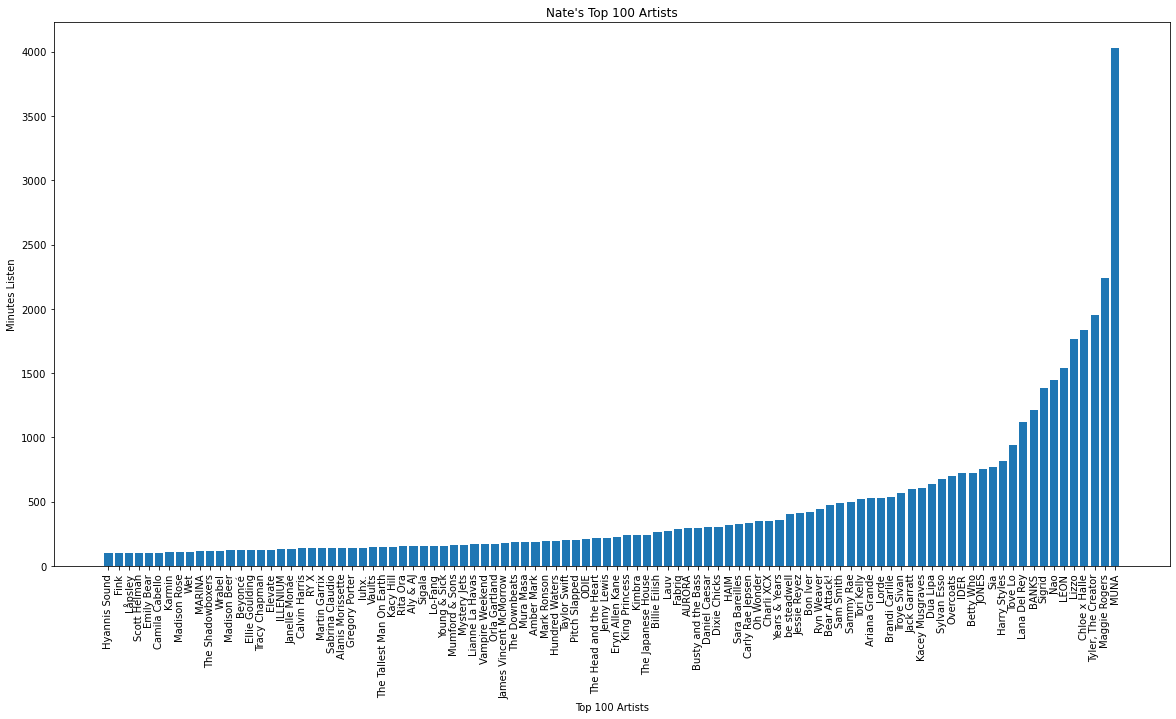

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x=total_played.iloc[-100:].index, height=total_played.iloc[-100:].values)
plt.xticks(rotation=90)
ax.set_xlabel('Top 100 Artists')
ax.set_ylabel('Minutes Listen')
ax.set_title('Nate\'s Top 100 Artists')

In [14]:
artists_to_consider = total_played[total_played > 120].index
artists_to_consider = total_played.index[-25:]
artists_to_consider

Index(['Ariana Grande', 'Lorde', 'Brandi Carlile', 'Troye Sivan',
       'Jack Garratt', 'Kacey Musgraves', 'Dua Lipa', 'Sylvan Esso',
       'Overcoats', 'IDER', 'Betty Who', 'JONES', 'Sia', 'Harry Styles',
       'Tove Lo', 'Lana Del Rey', 'BANKS', 'Sigrid', 'Nao', 'LÉON', 'Lizzo',
       'Chloe x Halle', 'Tyler, The Creator', 'Maggie Rogers', 'MUNA'],
      dtype='object', name='artistName')

In [15]:
total_played.index[-25:]

Index(['Ariana Grande', 'Lorde', 'Brandi Carlile', 'Troye Sivan',
       'Jack Garratt', 'Kacey Musgraves', 'Dua Lipa', 'Sylvan Esso',
       'Overcoats', 'IDER', 'Betty Who', 'JONES', 'Sia', 'Harry Styles',
       'Tove Lo', 'Lana Del Rey', 'BANKS', 'Sigrid', 'Nao', 'LÉON', 'Lizzo',
       'Chloe x Halle', 'Tyler, The Creator', 'Maggie Rogers', 'MUNA'],
      dtype='object', name='artistName')

In [16]:
t1 = df.endTime.iloc[0]
dt = datetime.datetime.strptime(t1, '%Y-%m-%d %H:%M')

In [17]:
def get_month(x):
    dt = datetime.datetime.strptime(x, '%Y-%m-%d %H:%M')
    return f'{dt.year}-{dt.month}'
    

In [18]:
df['year-month'] = df.endTime.apply(get_month)
df

,index,endTime,artistName,trackName,msPlayed,year-month
0,0,2019-02-20 01:12,Nao,If You Ever (feat. 6LACK),221735,2019-2
1,1,2019-02-20 01:16,Nao,Make It Out Alive (feat. SiR),212750,2019-2
2,2,2019-02-20 01:19,Calvin Harris,Promises (with Sam Smith),1312,2019-2
3,3,2019-02-20 01:19,Sam Smith,Dancing With A Stranger (with Normani),171029,2019-2
4,4,2019-02-20 01:22,Sam Smith,Dancing With A Stranger (with Normani),171456,2019-2
...,...,...,...,...,...,...
28901,8901,2020-02-20 23:21,Vaults,Overcome,1320,2020-2
28903,8903,2020-02-20 23:21,Dixie Chicks,Easy Silence,990,2020-2
28899,8899,2020-02-20 23:21,AURORA,"Murder Song (5, 4, 3, 2, 1)",1300,2020-2
28900,8900,2020-02-20 23:21,Journey,Lights,160586,2020-2


In [19]:

for ym in df['year-month'].unique():
    ym_df = df[df['year-month'] == ym].groupby(['artistName']).sum()
    ym_df

In [20]:
ym_df.loc[artists_to_consider[-1]].msPlayed

3581377

In [41]:
from collections import OrderedDict
results_dict = OrderedDict()

for artist in artists_to_consider:
    results_dict[artist] = OrderedDict()
    for ym in df['year-month'].unique():
        results_dict[artist][ym] = 0


results_dict

OrderedDict([('Ariana Grande',
              OrderedDict([('2019-2', 0),
                           ('2019-3', 0),
                           ('2019-4', 0),
                           ('2019-5', 0),
                           ('2019-6', 0),
                           ('2019-7', 0),
                           ('2019-8', 0),
                           ('2019-9', 0),
                           ('2019-10', 0),
                           ('2019-11', 0),
                           ('2019-12', 0),
                           ('2020-1', 0),
                           ('2020-2', 0)])),
             ('Lorde',
              OrderedDict([('2019-2', 0),
                           ('2019-3', 0),
                           ('2019-4', 0),
                           ('2019-5', 0),
                           ('2019-6', 0),
                           ('2019-7', 0),
                           ('2019-8', 0),
                           ('2019-9', 0),
                           ('2019-10', 0),
               

In [42]:
grouped_df = df[df.artistName.apply(lambda x: x in artists_to_consider)].groupby(['year-month', 'artistName'])

In [43]:
for (ym, artist), small_df in grouped_df:
    print(artist, ym)
    print(small_df.msPlayed.sum() / 60000)
    print()
    results_dict[artist][ym]= small_df.msPlayed.sum() / 60000

Ariana Grande 2019-10
12.90455

BANKS 2019-10
27.162316666666666

Betty Who 2019-10
2.965333333333333

Brandi Carlile 2019-10
29.3863

Chloe x Halle 2019-10
147.42081666666667

Dua Lipa 2019-10
17.633266666666668

JONES 2019-10
263.0939333333333

Jack Garratt 2019-10
2.5976166666666667

Kacey Musgraves 2019-10
3.7556

Lana Del Rey 2019-10
53.3067

Lizzo 2019-10
91.09766666666667

Lorde 2019-10
53.43828333333333

LÉON 2019-10
125.63515

MUNA 2019-10
624.863

Maggie Rogers 2019-10
250.8444

Nao 2019-10
74.63093333333333

Overcoats 2019-10
10.474483333333334

Sia 2019-10
18.6627

Sigrid 2019-10
84.42785

Sylvan Esso 2019-10
3.263333333333333

Tove Lo 2019-10
39.79465

Troye Sivan 2019-10
4.289766666666667

Tyler, The Creator 2019-10
13.186366666666666

Ariana Grande 2019-11
11.829233333333333

BANKS 2019-11
10.821316666666666

Betty Who 2019-11
35.24401666666667

Brandi Carlile 2019-11
5.88055

Chloe x Halle 2019-11
14.008883333333333

Harry Styles 2019-11
137.08151666666666

IDER 2019-11

In [45]:
to_del = []
for artist, artist_dict in results_dict.items():
    if max(list(artist_dict.values())) < 360:
        print(max(list(artist_dict.values())))
        to_del.append(artist)
        
for d in to_del:
    del results_dict[d]

235.34948333333332
85.18
270.22083333333336
117.19645
206.15368333333333
113.95083333333334
184.59756666666667
209.42256666666665
288.42581666666666
263.0939333333333
316.3968
172.02701666666667
231.32666666666665


Text(0.5, 1.0, "Nate's Music Peaks")

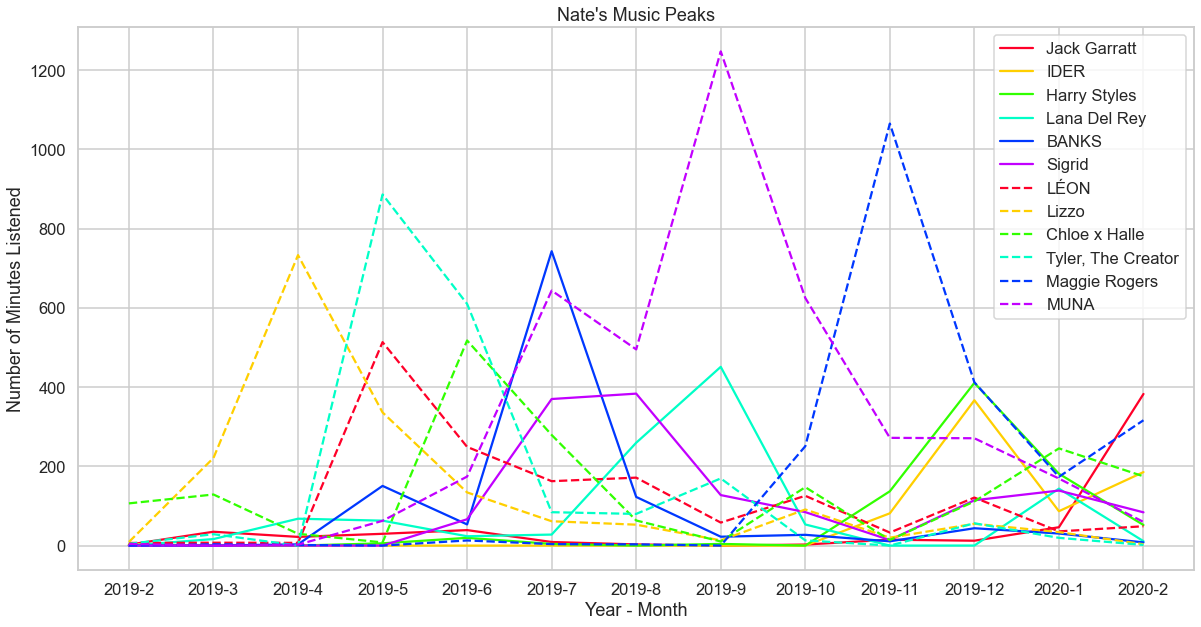

In [46]:

sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20,10))
cm = plt.get_cmap('gist_rainbow')
colors = [cm(i/5.5) for i in range(6)]
linestyles = ['-','--','-.',':']
combos = list(itertools.product(linestyles, colors))

for i, (artist, artist_dict) in enumerate(results_dict.items()):
    ls, c = combos[i]
    
    ax.plot(range(len(artist_dict.keys())), list(artist_dict.values()), label=artist, color=c, linestyle=ls)
    
ax.legend()
ax.set_xticks(range(len(artist_dict.keys())))
ax.set_xticklabels(list(artist_dict.keys()))
ax.set_ylabel('Number of Minutes Listened')
ax.set_xlabel('Year - Month')
ax.set_title('Nate\'s Music Peaks')
